In [1]:
import matplotlib.pyplot as plt
import numpy as np
import math

In [2]:
def f(x):
    return x**2 + 3*x

In [3]:
t = np.arange(-10, 10, 1)
t

array([-10,  -9,  -8,  -7,  -6,  -5,  -4,  -3,  -2,  -1,   0,   1,   2,
         3,   4,   5,   6,   7,   8,   9])

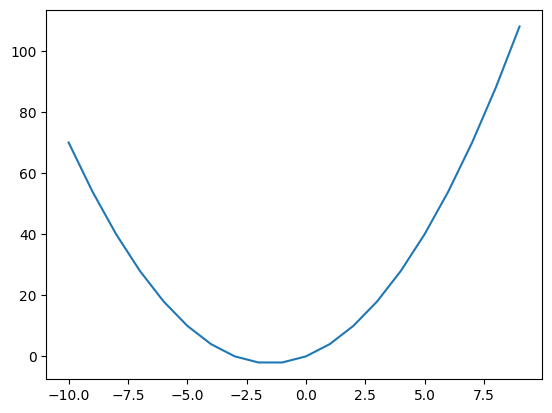

In [4]:
plt.plot(t, f(t))

In [5]:
a = 5
b = 3
c = 9
h = 0.001
# r = a*b + c
r1 = a*b + c
r2 = a*b + c+h

# dr/da = 3
# dr/db = 5
# dr/dc = 1
dr_dc = (r2 - r1)/h
print(r1)
print(r2)
print(dr_dc)

24
24.001
1.0000000000012221


In [6]:
class Scalar:
    def __init__(self, value,label = '', _children = (), _op = ''):
        self.value = value
        self._prev = _children 
        self._op = _op
        self.grad = 0.0
        self.label = label
        
    def __add__(self, other):
        other = other if isinstance(other, Scalar) else Scalar(other)
        out = self.value + other.value
        return Scalar(out, _children = (self, other), _op = '+')

    def __radd__(self, other):
        other = other if isinstance(other, Scalar) else Scalar(other)
        out = self.value + other.value
        return Scalar(out, _children = (self, other), _op = '+')
    
    def __sub__(self, other):
        other = other if isinstance(other, Scalar) else Scalar(other)
        out = self.value - other.value
        return Scalar(out, _children = (self, other), _op = '-')
    
    def __rsub__(self, other):
        other = other if isinstance(other, Scalar) else Scalar(other)
        out = other.value - self.value
        return Scalar(out, _children = (self, other), _op = '-')
        
    def __mul__(self, other):
        other = other if isinstance(other, Scalar) else Scalar(other)
        out = self.value * other.value
        return Scalar(out, _children = (self, other), _op = '*')

    def __rmul__(self, other):
        other = other if isinstance(other, Scalar) else Scalar(other)
        out = self.value * other.value
        return Scalar(out, _children = (self, other), _op = '*')

    def __pow__(self, other):
        other = other if isinstance(other, Scalar) else Scalar(other)
        out = self.value ** other.value
        return Scalar(out, _children = (self, other), _op = '**')
    
    def tanh(self):
        return Scalar(math.tanh(self.value), _children = (self, ), _op = "tanh")
        
    
    def __repr__(self):
        return f"Scalar(value={str(self.value)})"

In [7]:
from graphviz import Digraph


In [8]:
def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root, format='svg', rankdir='LR'):
    """
    format: png | svg | ...
    rankdir: TB (top to bottom graph) | LR (left to right)
    """
    assert rankdir in ['LR', 'TB']
    nodes, edges = trace(root)
    dot = Digraph(format=format, graph_attr={'rankdir': rankdir}) #, node_attr={'rankdir': 'TB'})
    
    for n in nodes:
        dot.node(name=str(id(n)), label = "{ % | data %.4f | grad %.4f }" % (n.label,n.value, n.grad), shape='record')
        if n._op:
            dot.node(name=str(id(n)) + n._op, label=n._op)
            dot.edge(str(id(n)) + n._op, str(id(n)))
    
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot

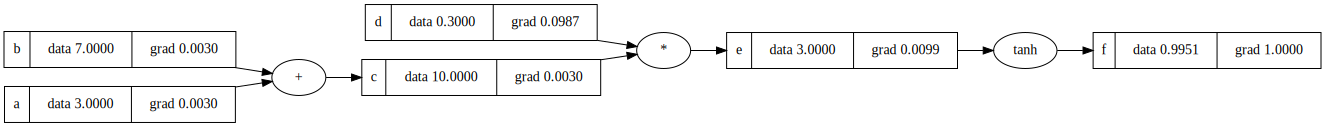

In [53]:
draw_dot(f)

In [51]:
a = Scalar(3.0) 
a.label = 'a'
b = Scalar(7.0)
b.label = 'b'
c = b + a
c.label = 'c'
d = Scalar(0.3)
d.label = 'd'
e = c * d
e.label = 'e'
f = e.tanh()
f.label = 'f'


# df/df
df_df = 1.0
f.grad = df_df

# df/de
df_de = 1 - e.tanh()**2
e.grad = df_de.value

# df/dd = df/de * de/dd
de_dd = c.value
df_dd = df_de * de_dd
d.grad = df_dd.value

# df/dc = df/de * de/dc
de_dc = d.value
df_dc = df_de * de_dc
c.grad = df_dc.value

# df/db = df/de * de/dc * dc/db
dc_db = 1.0
df_db = df_de * de_dc * dc_db
b.grad = df_db.value

# df/da = df/de * de/dc * dc/da
dc_da = 1.0
df_da = df_de * de_dc * dc_da
a.grad = df_da.value




print(f"a : {a.value} Gradient of a: {a.grad}")
print(f"b : {b.value} Gradient of b: {b.grad}")
print(f"a : {d.value} Gradient of c: {d.grad}")


a : 3.0 Gradient of a: 0.0029598111496320634
b : 7.0 Gradient of b: 0.0029598111496320634
a : 0.3 Gradient of c: 0.09866037165440211


In [52]:
def test_grads():
    import torch

    # Define variables with requires_grad=True to track computation for gradients
    a = torch.tensor(3.0, requires_grad=True)
    b = torch.tensor(7.0, requires_grad=True)
    c = b + a

    d = torch.tensor(0.3, requires_grad=True)
    
    # Define intermediate variables
    e = c * d
    f = e.tanh()


    # Compute gradients
    f.backward()
    # Print gradients
    print(f"a : {a.data} Gradient of a: {a.grad}")
    print(f"b : {b.data} Gradient of b: {b.grad}")
    print(f"d : {d.data} Gradient of c: {d.grad}")

test_grads()

a : 3.0 Gradient of a: 0.0029597945977002382
b : 7.0 Gradient of b: 0.0029597945977002382
d : 0.30000001192092896 Gradient of c: 0.09865981340408325
